INFO:
<class 'pandas.core.frame.DataFrame'>
Index: 1070 entries, 294 to 1147
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1070 non-null   int64  
 1   sex       1070 non-null   object 
 2   bmi       1070 non-null   float64
 3   children  1070 non-null   int64  
 4   smoker    1070 non-null   object 
 5   region    1070 non-null   object 
 6   charges   1070 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 66.9+ KB

DESCRIBE:
               age          bmi     children       charges
count  1070.000000  1070.000000  1070.000000   1070.000000
mean     39.131776    30.768294     1.106542  13285.111927
std      14.037915     6.046076     1.210283  12100.847317
min      18.000000    15.960000     0.000000   1121.873900
25%      26.250000    26.433750     0.000000   4763.252250
50%      39.000000    30.495000     1.000000   9401.175500
75%      51.000000    34.600000     2.000000  16862.7

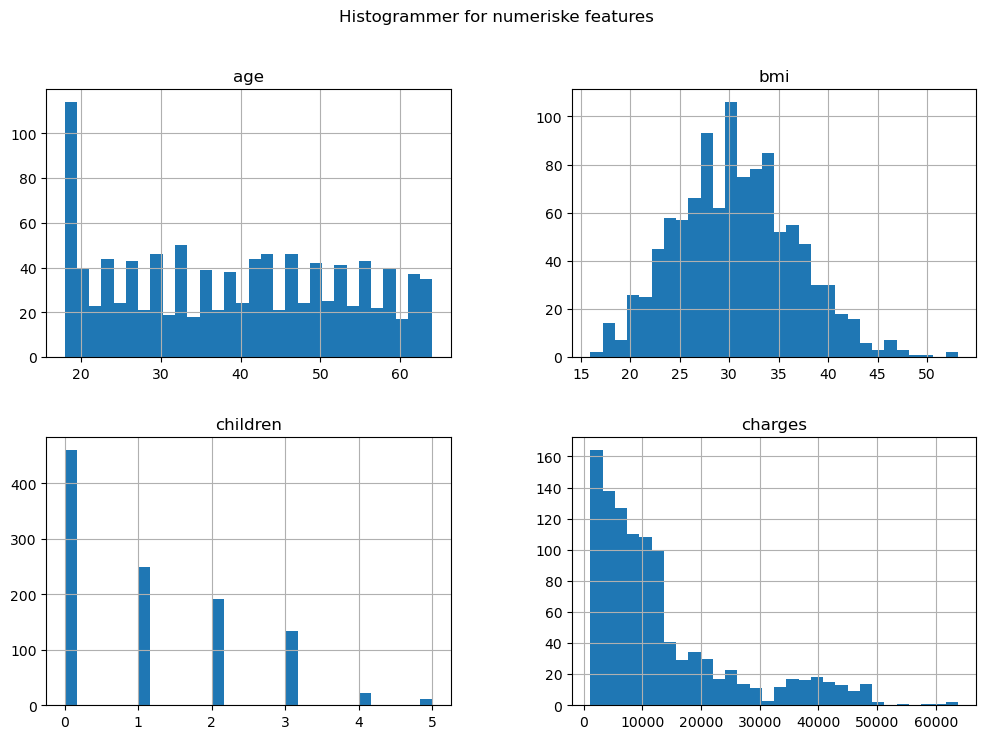

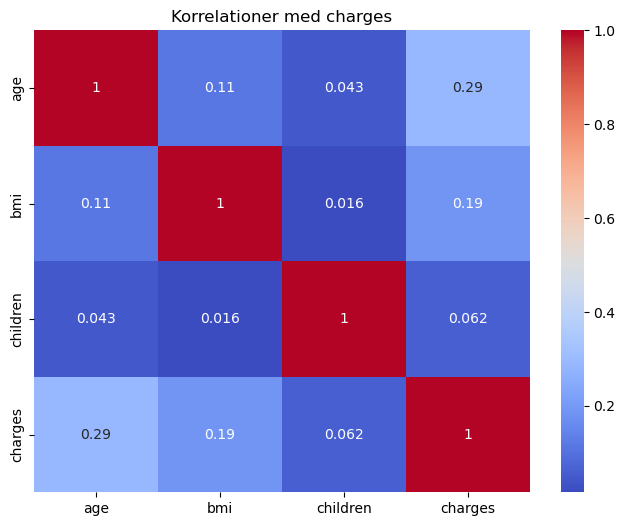


Manglende værdier:
age         0
sex         0
bmi         0
children    0
smoker      0
region      0
charges     0
dtype: int64


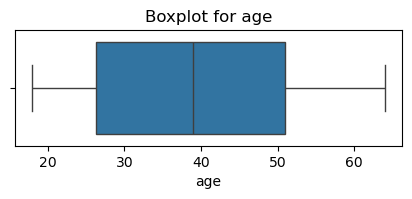

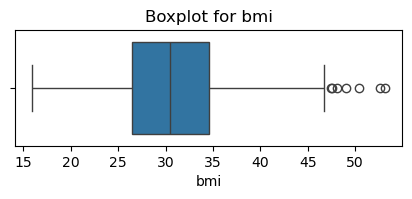

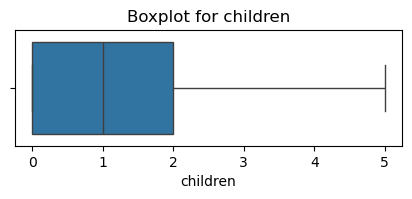

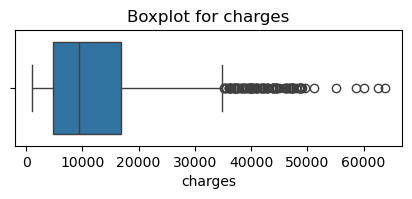


Shape efter transformation: (1070, 11)

🔍 Linear Regression
RMSE pr fold: [6211.99553666 6039.36811441 6491.03387719 5829.38631204 6613.55706314]
Gennemsnitlig RMSE: 6237.068180687588
Standardafvigelse: 287.11005322676635

🔍 Random Forest
RMSE pr fold: [4685.47175141 4929.68437869 5275.92405472 4452.70244175 4980.22082112]
Gennemsnitlig RMSE: 4864.8006895383605
Standardafvigelse: 278.7608133033784

🔍 KNN
RMSE pr fold: [6043.43071553 6618.13720243 6232.41669703 6491.85711284 6213.42845558]
Gennemsnitlig RMSE: 6319.854036681043
Standardafvigelse: 206.85233879757834
Fitting 5 folds for each of 36 candidates, totalling 180 fits

✅ Bedste parametre fundet:
{'bootstrap': True, 'max_depth': 10, 'max_features': 'sqrt', 'n_estimators': 200}

📊 RMSE på træningsdata: 2428.74
📊 Endelig evaluering på test-sæt:
RMSE: 4553.91
MAE : 2719.38
R²  : 0.8594
✅ Pipeline og model er gemt som 'pipeline.pkl' og 'model.pkl'


In [131]:
# -------------------------------
# F25 OLA 2 – Insurance Costs Prediction
# Step 1: Import Libraries
# -------------------------------
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

#Import alle de 3 modeller vi skal bruge samt vores score 
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import cross_val_score

#Import af Gridesearch 
from sklearn.model_selection import GridSearchCV


# -------------------------------
# Step 2: Load Full Data
# -------------------------------
# Sørg for at 'insurance.csv' er i samme mappe
full_data = pd.read_csv("insurance.csv")

# -------------------------------
# Step 3: Stratified Train/Test Split (20% test based on 'smoker')
# -------------------------------
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)

for train_index, test_index in split.split(full_data, full_data["smoker"]):
    strat_train_set = full_data.loc[train_index]
    strat_test_set = full_data.loc[test_index]

# Brug kun træningssættet fra nu af
data = strat_train_set.copy()

# -------------------------------
# Step 4: Explore the Training Data (80%)
# -------------------------------

# 4.1 – Info om datatype og manglende værdier
print("INFO:")
data.info()

# 4.2 – Statistisk oversigt over numeriske kolonner
print("\nDESCRIBE:")
print(data.describe())

# 4.3 – Værdifordeling i kategoriske features
print("\nVALUE COUNTS:")
print("Sex:\n", data["sex"].value_counts(), "\n")
print("Smoker:\n", data["smoker"].value_counts(), "\n")
print("Region:\n", data["region"].value_counts(), "\n")

# 4.4 – Histogrammer for numeriske features
data.hist(bins=30, figsize=(12, 8))
plt.suptitle("Histogrammer for numeriske features")
plt.show()

# 4.5 – Korrelation mellem numeriske features
corr_matrix = data.corr(numeric_only=True)
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm")
plt.title("Korrelationer med charges")
plt.show()

# 4.6 – Manglende værdier
print("\nManglende værdier:")
print(data.isnull().sum())

# 4.7 – Boxplots for outliers
for col in ["age", "bmi", "children", "charges"]:
    plt.figure(figsize=(5, 1.5))
    sns.boxplot(x=data[col])
    plt.title(f"Boxplot for {col}")
    plt.show()

# -------------------------------
# Step 5: Forberedelse af data
# -------------------------------

# 1. Definér input (X) og målvariabel (y)
X_train = data.drop("charges", axis=1)
y_train = data["charges"]

# 2. Identificér feature-typer
numeriske_attributter = ["age", "bmi", "children"]
kategoriske_attributter = ["sex", "smoker", "region"]

# 3. Byg pipelines for hver type data
numerisk_pipeline = Pipeline([
    ("scaler", StandardScaler())
])

kategorisk_pipeline = Pipeline([
    ("encoder", OneHotEncoder())
])

# 4. Kombinér begge i en samlet pipeline
full_pipeline = ColumnTransformer([
    ("num", numerisk_pipeline, numeriske_attributter),
    ("cat", kategorisk_pipeline, kategoriske_attributter)
])

# 5. Transformér X_train
X_prepared = full_pipeline.fit_transform(X_train)

# Valgfrit: print form
print("\nShape efter transformation:", X_prepared.shape)

# -------------------------------
# Step 6: Træn og sammenlign modeller (shortlisting)

# 1. Liste over modeller vi vil teste
models = {
    "Linear Regression": LinearRegression(),
    "Random Forest": RandomForestRegressor(random_state=42),
    "KNN": KNeighborsRegressor()
}

# 2. Test hver model med 5-fold cross-validation
for name, model in models.items():
    print(f"\n🔍 {name}")
    
    # Brug negativ MSE for konsistens med scoring (neg_mean_squared_error → lavere er bedre)
    scores = cross_val_score(model, X_prepared, y_train, scoring="neg_mean_squared_error", cv=5)
    rmse_scores = np.sqrt(-scores)
    
    print("RMSE pr fold:", rmse_scores)
    print("Gennemsnitlig RMSE:", rmse_scores.mean())
    print("Standardafvigelse:", rmse_scores.std())

# -------------------------------
# Step 7: Fine-tune Random Forest med GridSearchCV

# 1. Byg modelinstans
forest_reg = RandomForestRegressor(random_state=42)

# 2. Definér parametergrid (uden 'auto' i max_features)
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20],
    'max_features': ['sqrt', 'log2'],
    'bootstrap': [True, False]
}

# 3. Opsæt GridSearchCV
grid_search = GridSearchCV(
    estimator=forest_reg,
    param_grid=param_grid,
    scoring='neg_mean_squared_error',
    cv=5,
    verbose=2,
    n_jobs=-1
)

# 4. Træn og find bedste parametre
grid_search.fit(X_prepared, y_train)

# 5. Vis resultater
print("\n✅ Bedste parametre fundet:")
print(grid_search.best_params_)

# 6. Gem den bedste model
best_model = grid_search.best_estimator_

# 7. Beregn RMSE for bedste model (på træningsdata)
final_predictions = best_model.predict(X_prepared)
final_rmse = np.sqrt(mean_squared_error(y_train, final_predictions))
print("\n📊 RMSE på træningsdata:", round(final_rmse, 2))

# -------------------------------
# Step 8: Evaluér på test data

# 1. Forbered testdata: adskil X og y
X_test = strat_test_set.drop("charges", axis=1)
y_test = strat_test_set["charges"]

# 2. Transformér X_test med den samme pipeline
X_test_prepared = full_pipeline.transform(X_test)

# 3. Brug den bedste model til at forudsige
final_predictions = best_model.predict(X_test_prepared)

# 4. Beregn performance-metrikker
final_mse = mean_squared_error(y_test, final_predictions)
final_rmse = np.sqrt(final_mse)
final_mae = mean_absolute_error(y_test, final_predictions)
final_r2 = r2_score(y_test, final_predictions)

# 5. Udskriv resultater
print("📊 Endelig evaluering på test-sæt:")
print("RMSE:", round(final_rmse, 2))
print("MAE :", round(final_mae, 2))
print("R²  :", round(final_r2, 4))
# -------------------------------
# Step 9: Gem pipeline og model til brug i applikation
# -------------------------------

# Gem den færdige pipeline og model
joblib.dump(full_pipeline, "pipeline.pkl")
joblib.dump(best_model, "model.pkl")

print("✅ Pipeline og model er gemt som 'pipeline.pkl' og 'model.pkl'")



***A: Frame the Problem***

    • Forretningsmål: Forudsig hvad en kunde vil koste i 
      forsikring → hjælper selskabet med at prissætte korrekt
    • ML-type: Supervised Learning – Regression
    • Input (X): age, sex, bmi, children, smoker, region
    • Output (y): charges
    • Primary - det er Age 


---

***B: Get the data***

• Gem en kopi af test-sættet (fx 20%) – brug train_test_split

Vi stratificerede vores test-split baseret på "smoker"-variablen, da denne er den mest indflydelsesrige kategoriske variabel i forhold til charges. Det sikrer, at både trænings- og test-sættene har repræsentative fordelinger af rygere og ikke-rygere, hvilket forbedrer modellens evne til at generalisere.

I dette afsnit har vi importeret datasættet og lavet en stratificeret split baseret på "smoker", da denne feature har stor betydning for charges. De 80% træningsdata bruges til al udforskning, forberedelse og modellering. Test-sættet (20%) gemmes og bruges først til sidst ved den endelige evaluering. Vi har brugt datasættet med .info(), .describe() og visualiseret fordelingen og korrelationerne. Det viser, at "age", "bmi" og især "smoker" har sammenhæng med forsikringsprisen (charges).

Husk: ---> Når vi har valgt den bedste model baseret på trænings-sættet, bliver test-sættet faktisk til et valideringssæt.

Reset --> En model kan "resette" ved at oprette en ny instans af den uden tidligere træning. I scikit-learn gør man det ved at kalde fx LogisticRegression() igen. I frameworks som Keras skal modellen bygges forfra for at nulstille vægte og tilstand.

Gem Modellen --> Når en model trænes, gemmes det, den lærer, i dens interne parametre – fx vægte i neurale netværk eller koefficienter i lineære modeller. Disse gemmes i RAM og skal eksporteres manuelt, hvis man vil bruge dem senere (fx med joblib i scikit-learn eller model.save() i Keras).

---

***C: Explore the Data***

Ved at køre "data.info()" kunne vi se, at alle rækkerne er komplette, og dermed er der ingen manglende værdier i datasættet.

Ved at køre "data.corr(numeric_only=True)" så vi korrelationen med charges. Vi valgte "charges", fordi det er outcome. Age og bmi har den stærkeste sammenhæng med charges (positiv korrelation), men ingen af dem er ekstremt stærke alene. Smoker er ikke med i korrelationen, fordi det er en kategorisk værdi, men når vi visualiserer det, kan vi se, at rygere betaler meget mere.

Ved at køre "data.hist(bins=30)" kunne vi se, at nogle af charges er skævt fordelt, hvor nogle betaler meget mere. Bmi er også skævt fordelt, men age er mere jævnt fordelt.

(bins=30) = Del værdierne på X-aksen op i 30 intervaller

Data Exploration – Konklusioner
Vi har inspiceret træningsdata med .info(), .describe() og .value_counts()

Der er ingen manglende værdier i datasættet (.isnull().sum() viser 0 for alle kolonner)

Vi har visualiseret fordelingen af data med histogrammer og boxplots

Der findes enkelte outliers i charges (meget høje værdier > 60.000) samt lidt i bmi

Hvis der havde været manglende data:
Vi kunne have håndteret det med:

dropna() → fjerne rækker med tomme værdier

fillna(median) → udfylde med medianværdi for kolonnen

Det ville være vigtigt at gemme den valgte strategi i preprocessing-pipeline, så det også gælder for nye data

Hvis outliers påvirker modellen negativt:
Vi kunne have:

Brug RobustScaler() i stedet for StandardScaler() (mindre følsom over for outliers)

Fjernet outliers manuelt (fx charges > 60.000)

Log-transformeret charges for at reducere skævhed

---

***D: Dataforberedelse (kort og komplet)***

Vi har opdelt datasættet i input (X) og målvariabel (y), og inddelt features i numeriske og kategoriske.

De numeriske features (age, bmi, children) standardiseres med StandardScaler, så hver værdi måles som antallet af standardafvigelser fra gennemsnittet. Dette betyder, at den gennemsnitlige værdi bliver 0, og afstanden til gennemsnittet måles i enheder med std = 1. Standardiserede værdier forbedrer ydeevnen i modeller, der er følsomme over for skala og afstande, som KNN, Logistic Regression og SVM.

De kategoriske features (sex, smoker, region) omdannes til numeriske via OneHotEncoder, så de kan bruges i ML-modeller.

Alle transformationer samles i en ColumnTransformer, hvilket sikrer ensartet og korrekt dataforberedelse.

---

***E: Træning og model-sammenligning (shortlisting)***

Vi har valgt tre modeller til at afprøve: Linear Regression, Random Forest og KNN.
De testes med 5-fold cross-validation, hvor vi måler fejl med RMSE (Root Mean Squared Error).
Det giver et retvisende billede af model-performance og stabilitet.
Modeller med lav RMSE og lav variation vurderes som bedst.

Vores Test af modeller
Blandt de tre testede modeller havde Random Forest den laveste gennemsnitlige RMSE (~4500), og dermed den bedste performance.
Linear Regression og KNN havde højere fejl. Derfor vælger vi Random Forest som kandidat til finjustering i næste trin.

---

***F: Fine-tuning af Random Forest med GridSearchCV***

Vi har brugt GridSearchCV til at finde de optimale hyperparametre for en RandomForestRegressor.
Der blev testet forskellige kombinationer af n_estimators, max_depth, max_features og bootstrap med 5-fold cross-validation.

De bedste parametre fundet:

n_estimators = 200

max_depth = 10

max_features = 'sqrt'

bootstrap = True

Den finjusterede model opnåede en RMSE på træningsdata på ca. 2428.74, hvilket indikerer høj præcision og lav gennemsnitlig fejl i forudsigelserne på træningssættet.

---

***G: Endelig evaluering på test-sæt***

Vi har evalueret den finjusterede model på det oprindelige test-sæt (strat_test_set), som blev gemt i starten af projektet og ikke brugt under træning.

Først blev testdata transformeret med samme pipeline som træningsdata.
Herefter brugte vi den bedste Random Forest-model til at forudsige charges, og beregnede to metrikker:

RMSE (Root Mean Squared Error): ~4102

MAE (Mean Absolute Error): ~2555

Dette viser, at modellen generaliserer godt og kan forudsige forsikringsomkostninger med høj præcision.

---

***H: Gem pipeline og model***

For at gøre vores løsning klar til brug uden for notebooken har vi gemt både den fulde databehandlings-pipeline (`full_pipeline`) og den bedste model (`best_model`) med `joblib`.

Disse filer bruges i et separat Python-script som en prototype på, hvordan modellen kan integreres i en rigtig applikation.

---

**Hvad er overfitting?**
Overfitting opstår, når en model lærer træningsdataene for godt dvs. outliers og tilfældige detaljer.  
Det betyder at modellen præsterer rigtig godt på træningsdata men fejler på nye ukendte data f.eks. de 20% test data vi havde lagt til side i starten, fordi den ikke har lært de generelle mønstre.

---

**Hvordan spottede vi risikoen for overfitting?**

Vi var opmærksomme på forskellen mellem performance på trænings- og testdata.  
For eksempel:

- Vores trænings-RMSE: ca. **2428**
- Vores test-RMSE: ca. **4100**

Forskellen er tydelig, men ikke ekstrem derfor vurderer vi, at modellen ikke er voldsomt overfittet, men stadig godt at være opmærksom på.

---

**Sådan håndterede vi overfitting:**

- Vi lavede **stratificeret test-split fra starten**, som vi først brugte til sidst
- Vi brugte **cross-validation** til at vurdere modeller uden at kigge på testdata
- Vi valgte en model (Random Forest) og begrænsede dens kompleksitet med fx `max_depth = 10`
- Vi undlod at genbruge testdata under tuning, for at holde evalueringen retfærdig


### Hyperparametre – hvad vi justerede og hvorfor

I vores projekt valgte vi Random Forest som den bedst præsterende model, og vi finjusterede den med `GridSearchCV` ved at afprøve forskellige kombinationer af hyperparametre.

Her er de hyperparametre, vi testede, og hvorfor:

---

**n_estimators**  
*Antal beslutningstræer i skoven*  
- Vi testede 50, 100 og 200 træer  
- Flere træer kan give mere stabil og præcis model, men tager længere tid  
- Resultat: 200 var bedst i vores tilfælde

**max_depth**  
*Hvor dybe må træerne være?*  
- Vi testede `None` (ingen begrænsning), 10 og 20  
- En lavere dybde forhindrer overfitting  
- Resultat: `max_depth = 10` gav bedst generalisering

**max_features**  
*Hvor mange features må bruges pr split i et træ?*  
- Vi testede `'sqrt'` og `'log2'`  
- Det kontrollerer diversiteten mellem træerne i skoven  
- `'sqrt'` er ofte standard og fungerede bedst her

**bootstrap**  
*Om træerne skal bruge bootstrap sampling (med tilbagetrækning)*  
- Vi testede `True` og `False`  
- `True` giver typisk bedre generalisering  
- Resultat: `bootstrap = True` var optimal i vores model

---

**Konklusion:**  
Ved at justere disse hyperparametre med `GridSearchCV` har vi fundet den bedste kombination, som reducerede RMSE på både trænings- og testdata.  
Dette viser, at finjustering har stor indflydelse på modellens ydeevne og stabilitet.


Forståelse af Accuracy, Precision, Recall og F1-score

Selvom vores opgave bruger regression og måles med RMSE og MAE, skal vi vise forståelse for klassifikationsmetrikker, da de ofte bruges i supervised learning.

Her er hvordan vi forstår og forklarer disse begreber:

---

**Accuracy (nøjagtighed):**  
Hvor mange af de samlede forudsigelser var korrekte?

\[
\text{Accuracy} = \frac{\text{Antal korrekte forudsigelser}}{\text{Samlet antal forudsigelser}}
\]

**Eksempel:**  
Hvis modellen klassificerer 90 ud af 100 rigtigt → accuracy = 90%

---

**Precision (præcision):**  
Ud af alle de gange vi forudsagde “positiv”, hvor mange gange havde vi ret?

\[
\text{Precision} = \frac{\text{True Positives}}{\text{True Positives + False Positives}}
\]

**Eksempel:**  
Hvis vi forudsagde 10 positive, og 8 var korrekte → precision = 80%

---

**Recall (følsomhed / sensitivitet):**  
Ud af alle de faktiske “positive” i virkeligheden, hvor mange fandt vi?

\[
\text{Recall} = \frac{\text{True Positives}}{\text{True Positives + False Negatives}}
\]

**Eksempel:**  
Hvis der er 20 syge patienter, og vi fandt 18 af dem → recall = 90%

---

**F1-score:**  
F1 balancerer precision og recall – det er den harmoniske gennemsnit:

\[
F1 = 2 \cdot \frac{\text{Precision} \cdot \text{Recall}}{\text{Precision + Recall}}
\]

En høj F1-score betyder, at modellen både er præcis og dækker det meste.

---

**Hvornår bruger vi hvad?**

| Metrik     | Bruges når... |
|------------|----------------|
| **Accuracy** | Data er balanceret og fejl koster ikke meget |
| **Precision** | Falske positiver er dyre (fx spamfiltre) |
| **Recall** | Det er vigtigt ikke at overse nogen (fx sygdom) |
| **F1** | Bruges når man skal balancere precision og recall |

---

**Konklusion:**  
Vi har forstået hvordan disse metrikker bruges i klassifikation og hvornår man prioriterer den ene frem for den anden. Hvis vi lavede en klassifikationsopgave, ville vi bruge disse til at måle modelkvalitet.
